# Dunkin assessment

In [2]:
# some imports used throughout script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def encode_biscuit_type(dataframe, biscuits):
    """
    Add new column to dataframe, chaanging biscui names to integers. 

    Args:
        dataframe (df): dataframe containing 'biscuit' column
        biscuits (list): list of biscuit names in correct order
    """
    # check biscuit column exists
    # do a test?
    try:
        biscuit_column = dataframe['biscuit']
        for i, biscuit in enumerate(biscuits):
            biscuit_column = np.where([biscuit_column==biscuit], i, biscuit_column)[0]
            
        dataframe['encoded biscuit'] = biscuit_column
        
        print("added encoded biscuit column")
    except:
        raise ValueError("\"biscuit\" column does not exist in this dataframe.")

#### Big data collection

1. gamma: the tea surface tension, in N m−1
.
2. phi: the contact angle between the biscuit and the tea surface, in rad.
3. eta: the tea dynamic viscosity, in Pa s
4. L: the distance up the biscuit that the tea was visible, in m.
5. t: the time after initial dunking that the measurement was made, in s.
6. biscuit: the type of biscuit that was dunked, which is Rich Tea, Hobnob or Digestive.


In [4]:
# load in dunking-data, and show dataframe

big_data = pd.read_csv("dunking-data.csv")
print(f"shape: {big_data.shape}")
big_data.head()

shape: (3000, 6)


,gamma,phi,eta,L,t,biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob


In [5]:
# get names of all types of biscuits

biscuits = np.unique(big_data["biscuit"])
biscuits

array(['Digestive', 'Hobnob', 'Rich Tea'], dtype=object)

In [6]:
# encode names to integers

encode_biscuit_type(big_data, biscuits)
big_data.head()

added encoded biscuit column


,gamma,phi,eta,L,t,biscuit,encoded biscuit
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,0
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,0
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,0
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,1
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,1


# Classification of biscuit type 

In this section, a random forest classifier is trained and tested on the dunking-data.csv. It aims to be able to classify biscuit type from the provided data (phi,eta,L,t)



In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

train, test = train_test_split(big_data, test_size=0.4)

scaler = StandardScaler()
scaled_training_features = scaler.fit_transform(train.drop(['biscuit', 'encoded biscuit'], axis=1))
scaled_test_features = scaler.fit_transform(test.drop(['biscuit', 'encoded biscuit'], axis=1))

In [8]:
true_test_vals = np.array(test["encoded biscuit"].values, dtype=int)

In [9]:
# irrelevant?
train.head()

,gamma,phi,eta,L,t,biscuit,encoded biscuit
1508,0.061851,1.547116,0.001012,0.003432,21.366300,Digestive,0
1568,0.066211,1.500834,0.000987,0.003993,21.508126,Rich Tea,2
1990,0.087329,1.378664,0.000990,0.005204,10.205677,Rich Tea,2
2366,0.071906,1.257851,0.001015,0.007324,16.795999,Rich Tea,2
491,0.080199,1.531026,0.000991,0.005762,26.764818,Digestive,0


In [10]:
training_results = np.array(train['encoded biscuit'].values, dtype=int)
training_results
# len(results.values)

array([0, 2, 2, ..., 2, 2, 0])

In [11]:
# use GridSearchCV
rfc_param_grid = [
    {'n_estimators': [50, 1000]},
  {'max_features': [ None]}
 ]

svc_param_grid = [
  {'C': [5000, 1000, 100, 10, 5],  
  'gamma': [0.001, 0.01, 0.1, 8, 'scale', 'auto'], 
  'kernel': ['rbf']} 
 ]

In [12]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score

methods = {'Random Forest': [RandomForestClassifier, rfc_param_grid], 'SVM': [SVC, svc_param_grid] }
# grids = [rfc_param_grid, svc_param_grid]

current_f1 = 0
for i, method in methods.items():
    print(i)
    gscv = GridSearchCV(method[0](), method[1], scoring="f1_weighted")
    gscv.fit(scaled_training_features, training_results)
    print(f"{i} BEST ESTIMATOR: {gscv.best_estimator_}")
    
    if gscv.best_score_ > current_f1:
        print("Updating best model")
        print(f'Estimator Top F1-Score: {gscv.best_score_:.3f}')
        best_estimator = gscv.best_estimator_
        predicted_test_vals = best_estimator.predict(scaled_test_features)
        
        f1score = f1_score(true_test_vals, predicted_test_vals, average='weighted')
        
        print(f'True F1-Score: {f1score:.3f}')

Random Forest
Random Forest BEST ESTIMATOR: RandomForestClassifier(max_features=None)
Updating best model
Estimator Top F1-Score: 0.809
True F1-Score: 0.813
SVM
SVM BEST ESTIMATOR: SVC(C=5000, gamma=0.01)
Updating best model
Estimator Top F1-Score: 0.918
True F1-Score: 0.915


In [13]:
# from sklearn.svm import SVC

# SVC = SVC(C=5000, gamma=0.01, kernel='rbf')
# SVC.fit(scaled_training_features, training_results)
# predicted_test_vals= SVC.predict(scaled_test_features)
# len(predicted_test_vals)

In [14]:
test['encoded biscuit']

105     0
1894    1
2540    2
1126    2
2370    0
       ..
767     0
1857    1
239     0
978     2
258     2
Name: encoded biscuit, Length: 1200, dtype: object

In [15]:
# encoding test values to ints

# true_test_vals = np.array(test["encoded biscuit"].values, dtype=int)
# len(true_test_vals)

In [16]:
# compare raw number of predicted biscuit types and true biscuit types

max_num_predictions = 0
for i, biscuit in enumerate(biscuits):
    num_true_test_vals = len(true_test_vals[true_test_vals == i])
    num_pred_test_vals = len(predicted_test_vals[predicted_test_vals == i])
    print( f"Number of true {biscuit} values: {num_true_test_vals}")
    print( f"Number of predicted {biscuit} values: {num_pred_test_vals}")
    
    max_num_predictions = max(max_num_predictions, num_pred_test_vals)

Number of true Digestive values: 387
Number of predicted Digestive values: 386
Number of true Hobnob values: 403
Number of predicted Hobnob values: 395
Number of true Rich Tea values: 410
Number of predicted Rich Tea values: 419


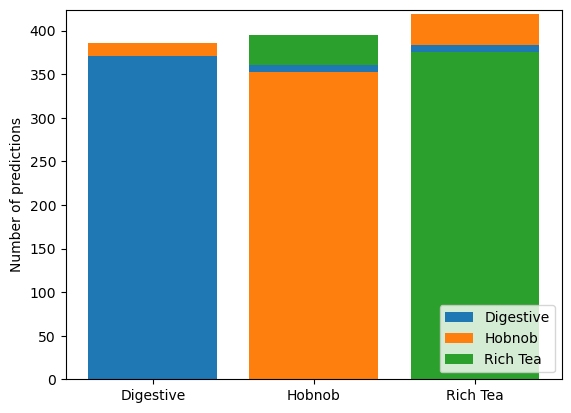

In [17]:
# plot bar chart

fig,ax = plt.subplots()

for i, biscuit in enumerate(biscuits):
    # Get values where this biscuit was predicted
    biscuit_prediction = np.where(predicted_test_vals==i, True, False)

    # Filter test values to just these biscuit predictions
    biscuit_test = true_test_vals[biscuit_prediction]
    
    # Number of correct predictions
    correct_predictions = len( biscuit_test[biscuit_test==i] )
    
    ax.bar(biscuit, correct_predictions, color=f"C{i}", label=biscuit)
    
    base = correct_predictions
    for j in range(len(biscuits)):
        if j != i:
            # NUmber of incorrect predictions, recording which biscuit was predicted instead
            incorrect_predictions = len( biscuit_test[biscuit_test==j] )
            ax.bar(biscuit, incorrect_predictions, bottom=base, color=f"C{j}")
            base += incorrect_predictions
            
ax.set_ylabel("Number of predictions")
ax.set_ylim(0, max_num_predictions+5)
ax.legend(loc="lower right");

In [18]:
# metrics

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'Precision: {precision:.3f}')

recall = recall_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'Recall: {recall:.3f}')

f1score = f1_score(true_test_vals, predicted_test_vals, average='weighted')
print(f'F1-Score: {f1score:.3f}')

Precision: 0.915
Recall: 0.915
F1-Score: 0.915


In [19]:
# importances = RFC.feature_importances_
# feature_names = big_data.drop(['biscuit', 'encoded biscuit'],axis=1).columns
# feature_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
# (feature_df)

#### comparison to true distribution

#### microscopy measurements

The final dataset was generated by taking a subset, one-sixth, of the dunking-data.csv samples and finding the pore radius by microscopy. This data file has similar information to the dunking-data.csv but without the biscuit type and with the pore radius. The columns, in order, are:

The final dataset is a subset of the training data.csv, where the biscuit type is no longer identified, but this has been replaced with the pore size as measured with microscopy. Therefore, this data also has six columns.

1. gamma: the tea surface tension, in N m−1
.
2. phi: the contact angle between the biscuit and the tea surface, in rad.
3. eta: the tea dynamic viscosity, in Pa s
4. L: the distance up the biscuit that the tea was visible, in m.
5. t: the time after initial dunking that the measurement was made, in s.
6. r: the radius of the pore, in m


In [20]:
microscopy_data = pd.read_csv("microscopy-data.csv")
microscopy_data.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


In [21]:
def washburn(gamma,r,t,phi,eta):
    """
    REDO
    A first order rate equation.
    
    :param gamma: The time to evaluate the rate equation at.
    :param r: The rate constant.
    :param t: The initial concentration of A.
    :param phi: The initial concentration of A.
    :param eta: The initial concentration of A.
    
    :return: The concentration of A at time t.
    """
    
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    return L

In [22]:
test_micro = microscopy_data.drop(['r'], axis=1)
test_micro.head()

,gamma,phi,eta,L,t
0,0.084596,1.557367,0.000981,0.003221,24.231107
1,0.064291,1.538842,0.000998,0.002395,22.169765
2,0.086224,1.546138,0.001008,0.003036,23.257709
3,0.082859,1.566878,0.000997,0.001261,12.717432
4,0.090832,1.570229,0.001002,0.000576,15.189146


In [23]:
scaled_test_micro = scaler.fit_transform(test_micro)
scaled_test_micro

array([[ 1.14599561,  1.1356957 , -1.85755021, -0.89683791,  0.77167231],
       [-0.89539042,  0.94168794, -0.27453187, -1.15666199,  0.41612889],
       [ 1.30966628,  1.01809608,  0.72485416, -0.95478295,  0.6037792 ],
       ...,
       [ 0.09739798,  1.10899036, -0.32077567, -0.953279  , -0.30290994],
       [ 0.82621258, -0.09441766,  1.04595373,  0.95980465, -0.10701664],
       [ 1.37150823,  0.79061851,  0.6782453 , -0.96069037, -1.44258582]])

In [24]:
micro_predictions = best_estimator.predict(scaled_test_micro)
len(micro_predictions)


500

In [25]:
training_merged = big_data.merge(microscopy_data, how='inner')
true_distributions = training_merged[['encoded biscuit', 'r']].copy()
true_distributions

,encoded biscuit,r
0,0,7.797961e-07
1,0,8.189772e-07
2,1,3.639434e-07
3,2,3.198697e-07
4,2,2.973448e-07
...,...,...
495,1,4.176549e-07
496,2,3.187500e-07
497,2,3.194081e-07
498,0,7.453712e-07


Text(0, 0.5, 'r')

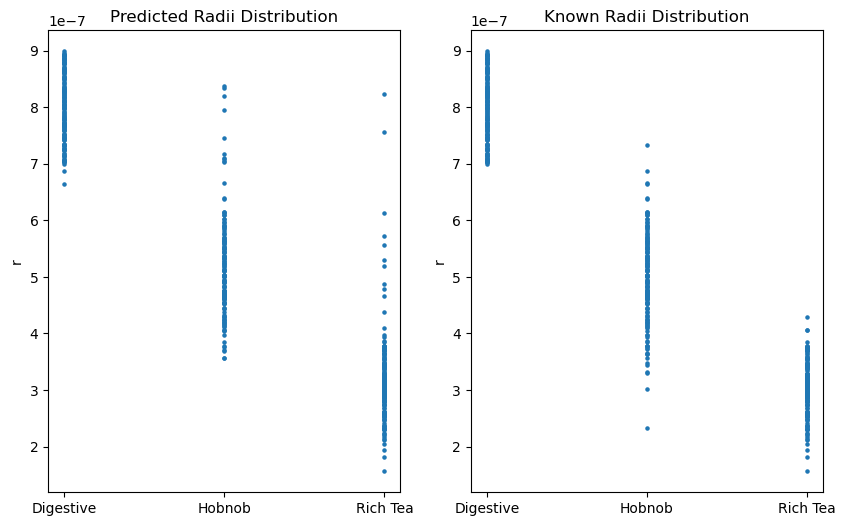

In [26]:
fig,ax=plt.subplots(1,2, figsize=(10,6))

ax[0].set_title("Predicted Radii Distribution")
ax[0].scatter(micro_predictions, microscopy_data["r"], s=5)
ax[0].set_xticks(np.arange(0, len(biscuits)))
ax[0].set_xticklabels(biscuits)
ax[0].set_ylabel("r")


ax[1].set_title("Known Radii Distribution")
ax[1].scatter(true_distributions['encoded biscuit'], true_distributions["r"], s=5)
ax[1].set_xticks(np.arange(0, len(biscuits)))
ax[1].set_xticklabels(biscuits)
ax[1].set_ylabel("r")

In [27]:
map0 = np.where(micro_predictions==0, True, False)
microscopy_data["r"][map0]

9      8.919035e-07
12     7.250476e-07
19     7.137298e-07
22     7.894797e-07
29     8.604312e-07
           ...     
488    8.189772e-07
492    8.991764e-07
496    8.798032e-07
497    8.652230e-07
498    8.128785e-07
Name: r, Length: 159, dtype: float64

In [28]:
from scipy.stats import norm

def get_norm_distribution(data):
    mean = np.mean(data)
    std = np.std(data)
    distribution = norm.rvs(mean, std)
    return distribution.pdf()

Digestive
predicted mean: 8.04e-07
true mean: 8.03e-07
predicted std: 5.88e-08
true std: 5.8e-08

Hobnob
predicted mean: 5.19e-07
true mean: 4.96e-07
predicted std: 9.12e-08
true std: 8e-08

Rich Tea
predicted mean: 3.21e-07
true mean: 3.04e-07
predicted std: 8.13e-08
true std: 4.7e-08



Text(0.5, 1.0, 'Known Radii Distributions')

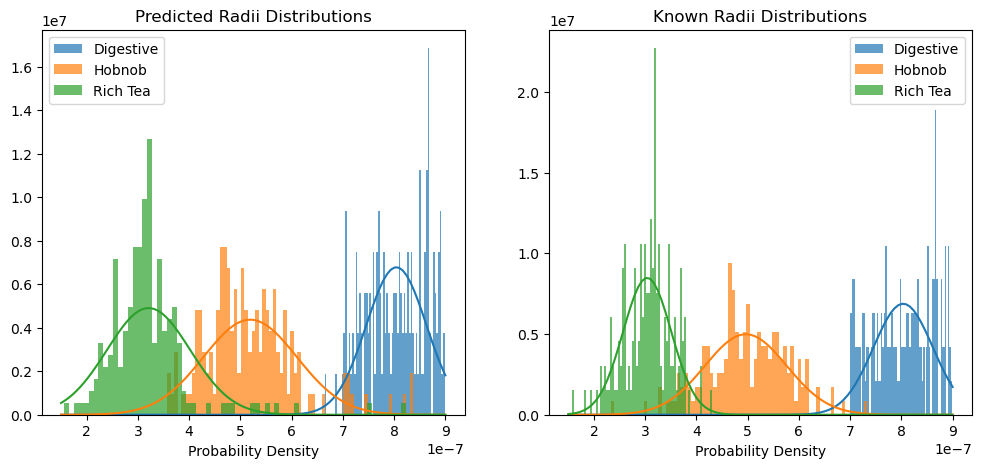

In [29]:
# plot as histogram

fig, ax = plt.subplots(1,2,figsize=(12,5))

pore_radii = []

distributions = {}

for i, biscuit in enumerate(biscuits):
    print(f"{biscuit}")
    map = np.where(micro_predictions==i, True, False)
    biscuit_r_data = microscopy_data["r"][map]
    ax[0].hist(biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    
    true_biscuit_r_data = true_distributions["r"][true_distributions['encoded biscuit']==i]
    ax[1].hist(true_biscuit_r_data, bins=70, alpha=0.7, density=True, label=biscuit)
    
    mean, std = norm.fit(biscuit_r_data)
    # xmin, xmax = plt.xlim()
    x = np.linspace(1.5e-7, 9e-7, 100)
    p = (norm.pdf(x, mean, std))
    pore_radii.append(mean)
    ax[0].plot(x,p, color=f"C{i}")
    
    distributions[biscuit] = {'mean': mean, 'std': std}
    
    
    true_mean, true_std = norm.fit(true_biscuit_r_data)
    # xmin, xmax = plt.xlim()
    x = np.linspace(1.5e-7, 9e-7, 100)
    p = (norm.pdf(x, true_mean, true_std))
    ax[1].plot(x,p, color=f"C{i}")
    print(f"predicted mean: {mean:.3}")
    print(f"true mean: {true_mean:.3}")
    print(f"predicted std: {std:.3}")
    print(f"true std: {true_std:.3}\n")
    
ax[0].set_xlabel("Pore radius size / m")
ax[0].set_xlabel("Probability Density")
ax[0].legend()
ax[0].set_title("Predicted Radii Distributions")
ax[1].set_xlabel("Pore radius size / m")
ax[1].set_xlabel("Probability Density")
ax[1].legend()
ax[1].set_title("Known Radii Distributions")

This figure shows that the model to classify biscuits is effective.

#### Time-resolved measurements
Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension was measured at 6.78 × 10−2 N m−1.

• the contact angle was 1.45 rad.

• the tea dynamic viscosity was 9.93 × 10−4 Pa s.

The biscuit used for each measurement is unknown, and the data files are titled tr-1.csv, tr-2.csv, and tr-3.csv. Each data file contains the same information, three columns of experimental data:

1. t: the time elapsed in the measurement, in s, the dependent variable.
2. L: the length the tea has soaked up the biscuit, the independent variable, in m.
3. dL: an estimate of the uncertainty in length, also in m.

In [30]:
tr_1 = pd.read_csv("tr-1.csv")
tr_2 = pd.read_csv("tr-2.csv")
tr_3 = pd.read_csv("tr-3.csv")

tr_3.head()

,t,L,dL
0,30.000000,0.011187,0.000371
1,32.727273,0.011566,0.000609
2,35.454545,0.011942,0.000809
3,38.181818,0.012502,0.000614
4,40.909091,0.013343,0.000480


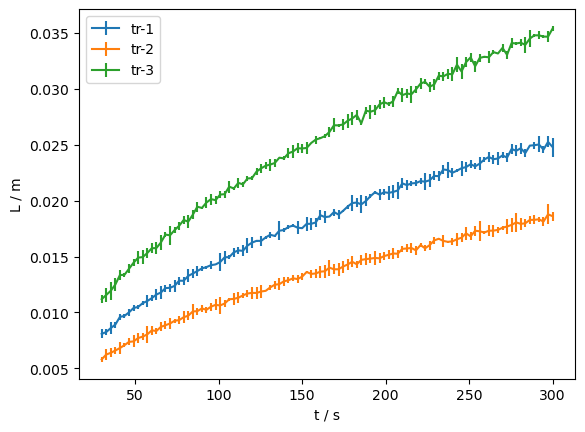

In [31]:
# show different trends

fig, ax = plt.subplots()

for i in range(1,4):
    data = pd.read_csv(f"tr-{i}.csv")
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    ax.errorbar(x,y,dy,label=f"tr-{i}")
    
ax.set_xlabel("t / s")
ax.set_ylabel("L / m")
ax.legend()

In [32]:
# assign time-resolved data to respective biscuit, in order from largest pore radius (Digestive) to smallest pore radius (Rich Tea)

tr_biscuits = [3,1,2]
for i, tr_val in enumerate(tr_biscuits):
    distributions[biscuits[i]]['tr_vals'] = pd.read_csv(f"tr-{tr_val}.csv")
    
distributions['Digestive']

{'mean': 8.044342310819825e-07,
 'std': 5.8786450437629365e-08,
 'tr_vals':              t         L        dL
 0    30.000000  0.011187  0.000371
 1    32.727273  0.011566  0.000609
 2    35.454545  0.011942  0.000809
 3    38.181818  0.012502  0.000614
 4    40.909091  0.013343  0.000480
 ..         ...       ...       ...
 95  289.090909  0.034766  0.000118
 96  291.818182  0.034769  0.000341
 97  294.545455  0.034655  0.000155
 98  297.272727  0.034646  0.000481
 99  300.000000  0.035373  0.000235
 
 [100 rows x 3 columns]}

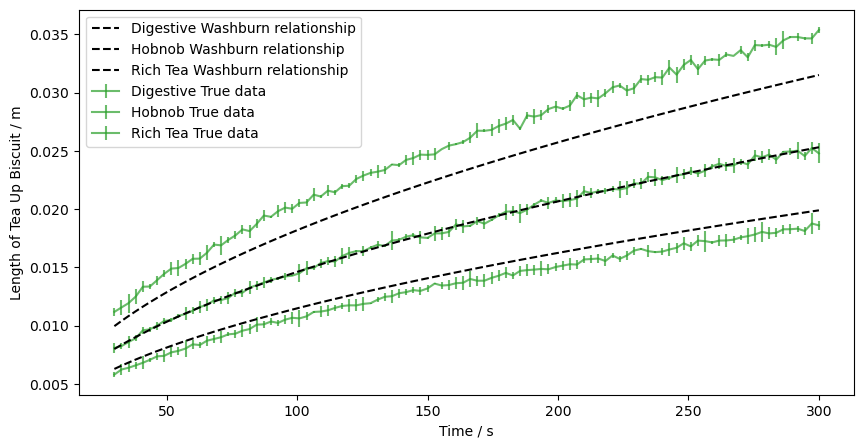

In [ ]:
# washburn model fittings using average pore radii for each biscuit

fig, ax = plt.subplots(figsize=(10,5))

for i, biscuit in enumerate(biscuits):
    data = distributions[biscuit]['tr_vals']
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    washburn_data_rfc = washburn(6.78e-2, distributions[biscuit]['mean'], data["t"], 1.45, 9.93e-4 )
    ax.errorbar(x,y,dy,label=f"{biscuit} True data", alpha=0.7, color=f"C{i}")
    
    ax.plot(data["t"], washburn_data_rfc, marker='', linestyle="--", color="black", zorder=3, label=f'{biscuit} Washburn relationship') 
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

This figure shows the Washburn relationship is likely an inaccurate model. However, there is a possibility the Digestive and Rich Tea biscuits used in these measurements had relavitely large/small pore sizes respectively. The following analysis determines the radii of the biscuits required for the Washburn model to accurately fit the real data. This will then be compared to the pore radius distributions, to determine the likelihood these pore radii are accurate, or if the model is inaccurate. 

In [34]:
# irrelevant?

import pymc as pm
import arviz as az


def run_pymc(data):
    
    D = [norm(data['L'][i], data['dL'][i]) for i in range(len(data))]
    
    with pm.Model() as model:
        gamma = 6.78e-2
        r = pm.Uniform('r', 1.5e-7, 1.2e-6)
        phi = 1.45
        eta = 9.93e-4
        
        L = pm.Normal('t', 
                    mu=washburn(gamma,r,data["t"],phi,eta), 
                    sigma=data['dL'], 
                    observed=data['L'])
        
        trace = pm.sample(1000, tune=1000, chains=10, progressbar=True)
        

    az.plot_trace(trace, var_names=["r"])
    plt.tight_layout()
    plt.show()
    
    return float(trace.posterior["r"].mean()), float(trace.posterior["r"].mean())

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 5 seconds.


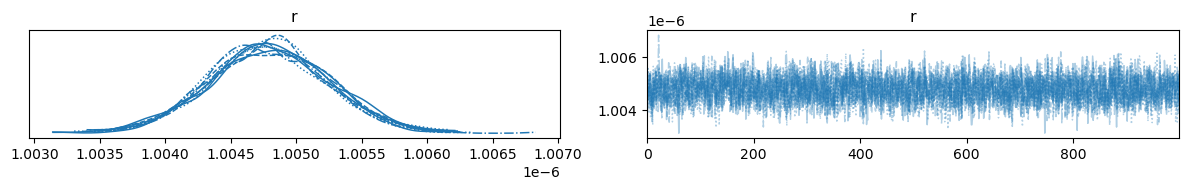

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.


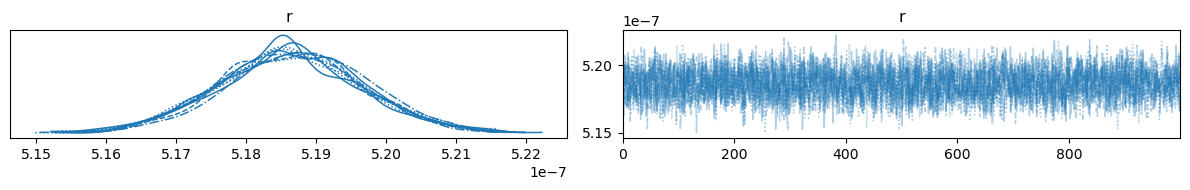

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 4 jobs)
NUTS: [r]


Output()

Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.


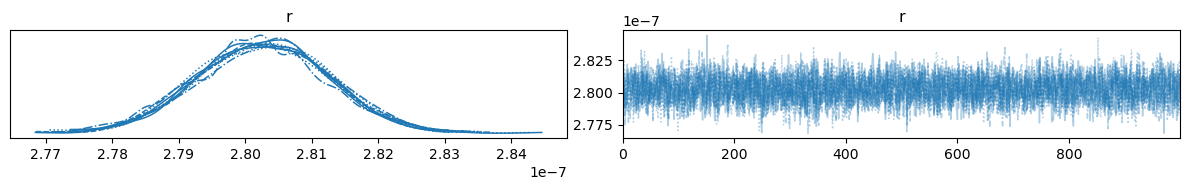

In [35]:
# find r for washburn to fit. 

for biscuit in biscuits:
    data = distributions[biscuit]['tr_vals']
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    pymc_r, pymc_std = run_pymc(data)
    
    distributions[biscuit]['pymc_r'] = pymc_r
    distributions[biscuit]['pymc_std'] = pymc_std


The required radius for the digestive comes out at over 1e-6, which is significantly greater than the mean. The following analysis determines the likelihood of each model getting this 

Digestive
predicted mean: 8.04e-07
true mean: 8.03e-07
predicted std: 5.9e-08
true std: 5.8e-08

Hobnob
predicted mean: 5.18e-07
true mean: 4.96e-07
predicted std: 9.02e-08
true std: 8e-08

Rich Tea
predicted mean: 3.23e-07
true mean: 3.04e-07
predicted std: 8.89e-08
true std: 4.7e-08

In [88]:
def calc_prob_in_distribution(mean, std, value):
    if value > mean:
        cum_prob = 1 - norm(mean, std).cdf(value)
    elif value < mean:
        cum_prob = norm(mean, std).cdf(value)
    # two-tailed
    percentage = 100*2*cum_prob
    print(f"probability of this value or more extreme occuring: {percentage:.2f} %")

In [89]:
for biscuit in biscuits:
    print(biscuit)
    biscuit_dict = distributions[biscuit]
    calc_prob_in_distribution(biscuit_dict['mean'], biscuit_dict['std'], biscuit_dict['pymc_r'])
    
    num_stds = abs( biscuit_dict['pymc_r'] - biscuit_dict['mean'] ) / biscuit_dict['std']
    print(f"Number of stds from mean: {num_stds}")

Digestive
probability of this value or more extreme occuring: 0.07 %
Number of stds from mean: 3.408202098758668
Hobnob
probability of this value or more extreme occuring: 99.62 %
Number of stds from mean: 0.004811257283222274
Rich Tea
probability of this value or more extreme occuring: 61.78 %
Number of stds from mean: 0.49902483252993635


From this analysis, it is clear that the Washburn equation is not a good prediction model. The probability of the predicted model being correct for Digestives and Rich Tea bisuits are extremely low, suggesting it is very unlikely the biscuits these samples were taken from have the pore radius predicted. This suggests there is instead something wrong with the model. 

#### An improved model? Regression

Digestive 0
8.044342310819825e-07
RMSE for Washburn model: 0.00274
RMSE for Polynomial regression model: 0.000331


Hobnob 1
5.190705071399475e-07
RMSE for Washburn model: 0.000185
RMSE for Polynomial regression model: 0.000239


Rich Tea 2
3.2083233778297603e-07
RMSE for Washburn model: 0.000998
RMSE for Polynomial regression model: 0.00019




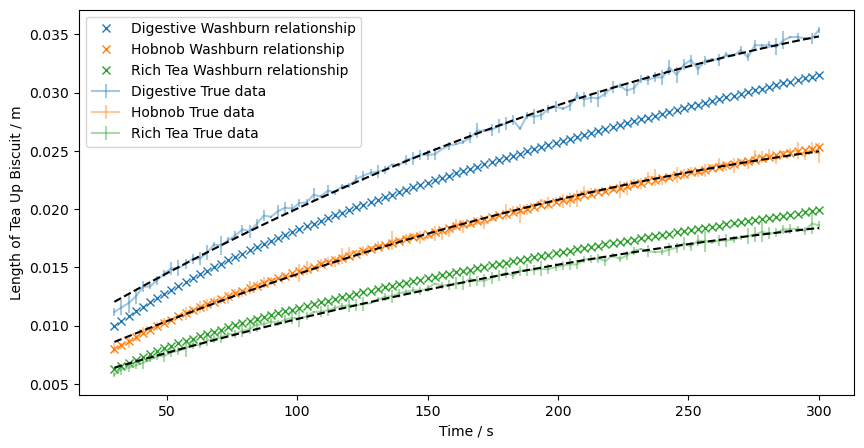

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(10,5))

tr_list = [3,1,2]
poly = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

for i, biscuit in enumerate(biscuits):
    print(f"{biscuit} {i}")
    
    biscuit_dict = distributions[biscuit]
    print(biscuit_dict['mean'])
    
    
    data = biscuit_dict['tr_vals']
    x = data["t"].values.reshape(-1,1)
    y = data["L"]
    dy = data["dL"]
    
    train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
    
    X_train = poly.fit_transform(train["t"].values.reshape(-1,1))
    y_train = train['L']
    
    model.fit(X_train, y_train)
    
    X_test = data['t'].values.reshape(-1,1)
    X_test_ = poly.fit_transform(X_test)
    
    y_test = test['L'].values
    
    washburn_data_rfc = washburn(6.78e-2, biscuit_dict['mean'], data["t"], 1.45, 9.93e-4 )
    ax.errorbar(x,y,dy,label=f"{biscuit} True data", alpha=0.4, color=f"C{i}")
    ax.plot(data['t'], model.predict(X_test_), linestyle='--', marker='', c='black', zorder=4)
    # ax.scatter(test['t'], y_test)
    
    ax.plot(data["t"], washburn_data_rfc, marker='x', linestyle="", color=f"C{i}", zorder=3, label=f'{biscuit} Washburn relationship') 
    
    mse_wash = np.sqrt(mean_squared_error(y , washburn_data_rfc))
    mse_reg =  np.sqrt(mean_squared_error(y , model.predict(X_test_)))
    
    print(f"RMSE for Washburn model: {mse_wash:.3}")
    print(f"RMSE for Polynomial regression model: {mse_reg:.3}")
    # print(model.coef_)
    print(f"\n")
    
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

Digestive 0
8.044342310819825e-07
RMSE for Washburn model: 0.00274
RMSE for Polynomial regression model: 0.00153


Hobnob 1
5.190705071399475e-07
RMSE for Washburn model: 0.000185
RMSE for Polynomial regression model: 0.000923


Rich Tea 2
3.2083233778297603e-07
RMSE for Washburn model: 0.000998
RMSE for Polynomial regression model: 0.00093




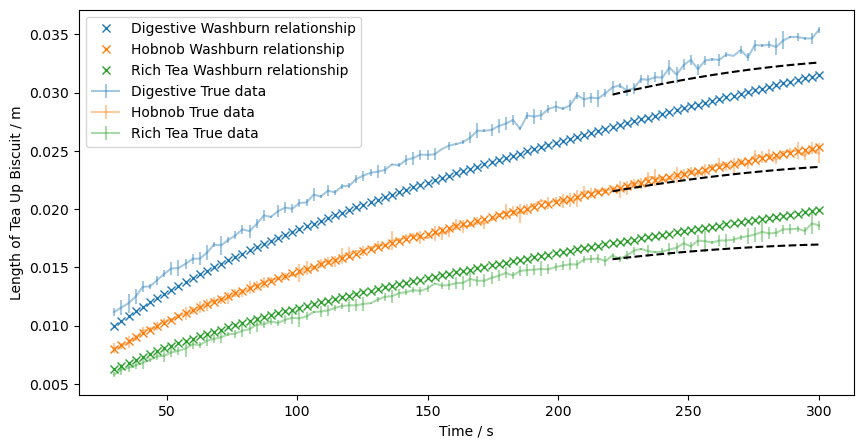

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(10,5))

tr_list = [3,1,2]
poly = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

for i, biscuit in enumerate(biscuits):
    print(f"{biscuit} {i}")
    
    biscuit_dict = distributions[biscuit]
    print(biscuit_dict['mean'])
    
    
    data = biscuit_dict['tr_vals']
    x = data["t"].values.reshape(-1,1)
    y = data["L"]
    dy = data["dL"]
    
    train, test = train_test_split(data, test_size=0.3, random_state=42, shuffle=False)
    
    X_train = poly.fit_transform(train["t"].values.reshape(-1,1))
    y_train = train['L']
    
    model.fit(X_train, y_train)
    
    X_test = test['t'].values.reshape(-1,1)
    X_test_ = poly.fit_transform(X_test)
    
    y_test = test['L'].values
    
    washburn_data_rfc = washburn(6.78e-2, biscuit_dict['mean'], data["t"], 1.45, 9.93e-4 )
    ax.errorbar(x,y,dy,label=f"{biscuit} True data", alpha=0.4, color=f"C{i}")
    ax.plot(test['t'], model.predict(X_test_), linestyle='--', marker='', c='black', zorder=4)
    # ax.scatter(test['t'], y_test)
    
    ax.plot(data["t"], washburn_data_rfc, marker='x', linestyle="", color=f"C{i}", zorder=3, label=f'{biscuit} Washburn relationship') 
    
    mse_wash = np.sqrt(mean_squared_error(y , washburn_data_rfc))
    mse_reg =  np.sqrt(mean_squared_error(y_test , model.predict(X_test_)))
    
    print(f"RMSE for Washburn model: {mse_wash:.3}")
    print(f"RMSE for Polynomial regression model: {mse_reg:.3}")
    print(f"\n")
    
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

In [40]:
tr_combined = pd.concat([tr_1, tr_2, tr_3])

In [41]:
# testing effectiveness of polynomial regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


data = pd.read_csv(f"tr-3.csv")
# data = tr_combined

poly = PolynomialFeatures(degree=2)
model = LinearRegression()

train, test = train_test_split(data, test_size=0.2, random_state=42)

X_ = poly.fit_transform(train["t"].values.reshape(-1,1))
y = train['L']

model.fit(X_, y)

reg_prediction = model.predict(X_)
####

X_test = test['t'].values.reshape(-1,1)
X_test_ = poly.fit_transform(X_test)

# true values
y_test = test['L'].values

mean_squared_error(y_test , model.predict(X_test_))

model.coef_

print("model:")
print(f"{model.coef_[0]:.8} t + {model.coef_[1]:.8} t**2 + {model.coef_[2]:.8} ")

model:
0.0 t + 0.00013274054 t**2 + -1.4671551e-07 


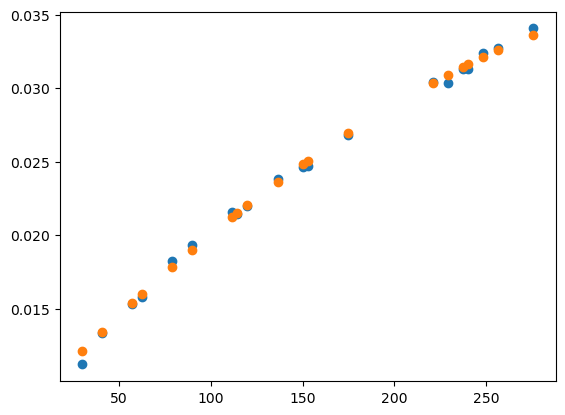

In [42]:
fig,ax = plt.subplots()
ax.scatter(test['t'], y_test)
ax.scatter(test['t'], model.predict(X_test_))

In [43]:
def reg_model(r, t):
    return (1.54e+02*r + -1.8e+07*(r**2) + 2.16e-05)*t + (-0.254*r + 9.33e+04*(r**2) + -3.76e-09)*(t**2) + (3.96e+03*r + 3.74e+09*(r**2) + 0.00272)

In [44]:
gamma = 6.78e-2
phi = 1.45
eta = 9.93e-4

constant = np.sqrt(gamma*np.cos(phi)/2*eta)

In [45]:
def calc_constant(t):
    gamma = 6.78e-2
    phi = 1.45
    eta = 9.93e-4

    constant = np.sqrt(gamma*t*np.cos(phi)/2*eta)
    return constant

Digestive
[ 1.32740541e-04 -1.46715507e-07]
0.000133*t + -1.47e-07*(t**2) + 0.00823
RMSE for Washburn model: 0.00274
RMSE for Polynomial regression model: 0.000337


Hobnob
[ 9.71774387e-05 -1.10956178e-07]
9.72e-05*t + -1.11e-07*(t**2) + 0.00581
RMSE for Washburn model: 0.000185
RMSE for Polynomial regression model: 0.00025


Rich Tea
[ 6.94213599e-05 -7.59637852e-08]
6.94e-05*t + -7.6e-08*(t**2) + 0.00439
RMSE for Washburn model: 0.000998
RMSE for Polynomial regression model: 0.00023




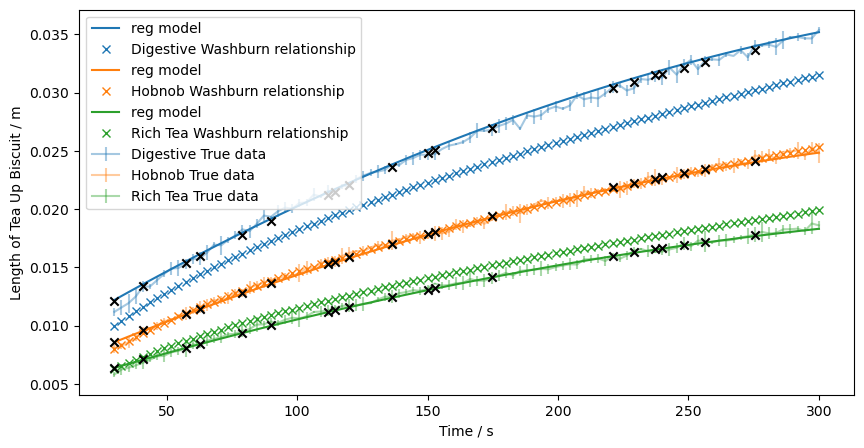

In [46]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(10,5))

tr_list = [3,1,2]
poly = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

coef0 = []
coef1 = []
intercepts = []

for i, tr_val in enumerate(tr_list):
    print(f"{biscuits[i]}")
    
    data = pd.read_csv(f"tr-{tr_val}.csv")
    # data['t'] = np.sqrt(data['t'])
    x = data["t"].values.reshape(-1,1)
    y = data["L"]
    dy = data["dL"]
    data['L'] = data['L']
    # data['L'] = (constant*np.sqrt(pore_radii[i])) / data['L']
    
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    
    X_train = poly.fit_transform(train["t"].values.reshape(-1,1))
    y_train = train['L']
    
    model.fit(X_train, y_train)
    
    X_test = test['t'].values.reshape(-1,1)
    X_test_ = poly.fit_transform(X_test)
    
    y_test = test['L'].values
    
    def model_fit(t):
        print(model.coef_)
        model_fit = model.coef_[0]*t + model.coef_[1]*(t**2) + model.intercept_
        print(f"{model.coef_[0]:.3}*t + {model.coef_[1]:.3}*(t**2) + {model.intercept_:.3}")
        return model_fit
    
    coef0.append(model.coef_[0])
    coef1.append(model.coef_[1])
    intercepts.append(model.intercept_)
    
    washburn_data_rfc = washburn(6.78e-2, pore_radii[i], data["t"], 1.45, 9.93e-4 )
    ax.errorbar(x,y,dy,label=f"{biscuits[i]} True data", alpha=0.4, color=f"C{i}")
    ax.scatter(test['t'], model_fit(test['t']), marker='x', c='black', zorder=4)
    ax.plot(data['t'], reg_model(pore_radii[i], data['t']), label='reg model')
    
    ax.plot(data["t"], washburn_data_rfc, marker='x', linestyle="", color=f"C{i}", zorder=3, label=f'{biscuits[i]} Washburn relationship') 
    
    mse_wash = np.sqrt(mean_squared_error(y , washburn_data_rfc))
    mse_reg =  np.sqrt(mean_squared_error(y_test , model.predict(X_test_)))
    
    print(f"RMSE for Washburn model: {mse_wash:.3}")
    print(f"RMSE for Polynomial regression model: {mse_reg:.3}")
    # print(model.coef_)
    print(f"\n")
    
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

In [47]:
pore_radii

[8.044342310819825e-07, 5.190705071399475e-07, 3.2083233778297603e-07]

In [48]:
import jax as jnp

def f(x):
    """
    An example function for JAX. 
    :param x: input to the function.
    :return: output of the function.
    """
    return jnp.square(x) + jnp.log(x)

In [49]:
# determine relationship between pore size and polynomial coefficients


poly = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

relationships = [coef0, coef1, intercepts]
for relationship in relationships:
    X_ = poly.fit_transform(np.array(pore_radii).reshape(-1,1))
    y = relationship

    model.fit(X_, y)
       
    print(model.coef_)
    print(f"{model.intercept_:.3} + {model.coef_[0]:.3}*r + {model.coef_[1]:.3}*(r**2) ")

    # fit = model_fit(pore_radii)

# reg_prediction = model.predict(X_)
####




[ 1.66742666e+02 -3.18237623e+07]
1.92e-05 + 1.67e+02*r + -3.18e+07*(r**2) 
[-2.65448897e-01  1.05883635e+05]
-1.7e-09 + -0.265*r + 1.06e+05*(r**2) 
[4.88898599e+03 2.71414748e+09]
0.00254 + 4.89e+03*r + 2.71e+09*(r**2) 


In [50]:
def reg_model(r, t):
    return (1.54e+02*r + -1.8e+07*(r**2) + 2.16e-05)*t + (-0.254*r + 9.33e+04*(r**2) + -3.76e-09)*(t**2) + (3.96e+03*r + 3.74e+09*(r**2) + 0.00272)

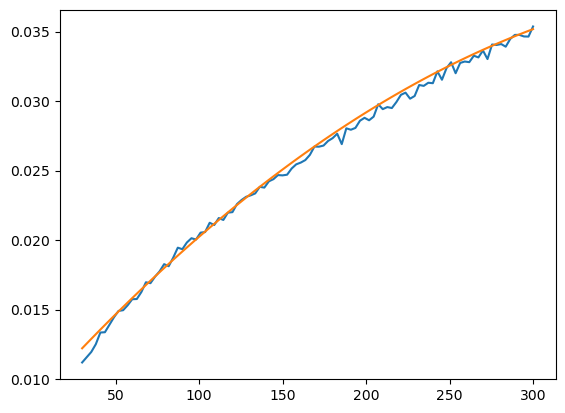

In [51]:
data = pd.read_csv("tr-3.csv")

fig,ax = plt.subplots()

ax.plot(data['t'], data['L'])
ax.plot(data['t'], reg_model(pore_radii[0], data['t']))

#### Neural network

In [52]:
training_merged

,gamma,phi,eta,L,t,biscuit,encoded biscuit,r
0,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,0,7.797961e-07
1,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,0,8.189772e-07
2,0.062276,1.520534,0.001005,0.004030,28.423407,Hobnob,1,3.639434e-07
3,0.075264,1.487706,0.001003,0.004726,21.984085,Rich Tea,2,3.198697e-07
4,0.073130,1.554126,0.000995,0.002234,27.632784,Rich Tea,2,2.973448e-07
...,...,...,...,...,...,...,...,...
495,0.070954,1.447903,0.000996,0.005560,17.524261,Hobnob,1,4.176549e-07
496,0.060301,1.466961,0.001004,0.004119,17.604523,Rich Tea,2,3.187500e-07
497,0.071658,1.303051,0.001003,0.008497,24.070251,Rich Tea,2,3.194081e-07
498,0.084596,1.557367,0.000981,0.003221,24.231107,Digestive,0,7.453712e-07


In [53]:
tr_1

,t,L,dL
0,30.000000,0.008087,0.000392
1,32.727273,0.008253,0.000270
2,35.454545,0.008607,0.000501
3,38.181818,0.008920,0.000267
4,40.909091,0.009604,0.000274
...,...,...,...
95,289.090909,0.024948,0.000307
96,291.818182,0.025015,0.000711
97,294.545455,0.024558,0.000322
98,297.272727,0.025243,0.000489


Digestive
predicted mean: 8.04e-07
true mean: 8.03e-07
predicted std: 5.92e-08
true std: 5.8e-08

Hobnob
predicted mean: 5.22e-07
true mean: 4.96e-07
predicted std: 9.18e-08
true std: 8e-08

Rich Tea
predicted mean: 3.21e-07
true mean: 3.04e-07
predicted std: 7.89e-08
true std: 4.7e-08

In [54]:
tr_1['r'] = 5.22e-7
tr_2['r'] = 3.21e-7
tr_3['r'] = 8.04e-7
tr_1

,t,L,dL,r
0,30.000000,0.008087,0.000392,5.220000e-07
1,32.727273,0.008253,0.000270,5.220000e-07
2,35.454545,0.008607,0.000501,5.220000e-07
3,38.181818,0.008920,0.000267,5.220000e-07
4,40.909091,0.009604,0.000274,5.220000e-07
...,...,...,...,...
95,289.090909,0.024948,0.000307,5.220000e-07
96,291.818182,0.025015,0.000711,5.220000e-07
97,294.545455,0.024558,0.000322,5.220000e-07
98,297.272727,0.025243,0.000489,5.220000e-07


In [55]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class RNNModel(nn.Module):
    """
    Create a simple RNN model with a single RNN layer, a dropout layer, and a fully connected layer.
    
    :param input_size: The number of features in the input data.
    :param hidden_size: The number of features in the hidden state.
    :param output_size: The number of features in the output data.
    :param dropout: The dropout rate.
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1, num_layers=2, dropout=0):
        super(RNNModel, self).__init__()
        
        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,  
            nonlinearity='tanh', 
            bias=True 
        )
        
        self.dropout = nn.Dropout(dropout) 
        self.fc = nn.Linear(hidden_size, output_size)  
        
    def forward(self, x):
        """
        Forward pass of the RNN model.
        
        :param x: The input data.
        :return: The output data.
        """
        if type(x) is np.ndarray:
            x = torch.tensor(x, dtype=torch.float32)[:, np.newaxis]
        rnn_out, _ = self.rnn(x)  
        rnn_out = self.dropout(rnn_out[:, -1]) 
        out = torch.sigmoid(self.fc(rnn_out)) 
        return out
    
    def perform_training(self, data, labels, epochs=100, lr=0.001):
        """
        Perform training of the RNN model.
        
        :param data: The input data.
        :param labels: The output data.
        :param epochs: The number of epochs.
        :param lr: The learning rate.
        """
        loss_fn = nn.BCELoss()
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)

        Xtrain_tensor = torch.tensor(data, dtype=torch.float32)[:, np.newaxis]
        ytrain_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)  # Reshape for BCELoss

        batch_size = 10
        train_dataset = TensorDataset(Xtrain_tensor, ytrain_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            self.train()  
            running_loss = 0.0
            for X_batch, y_batch in train_loader:
                optimiser.zero_grad()  
                outputs = self(X_batch)  
                loss = loss_fn(outputs, y_batch)  
                loss.backward()
                optimiser.step()  
                running_loss += loss.item()
            
            avg_loss = running_loss / len(train_loader) 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

class LSTMModel(nn.Module):
    """
    Create a simple LSTM model with a single LSTM layer, a dropout layer, and a fully connected layer.
    
    :param input_size: The number of features in the input data.
    :param hidden_size: The number of features in the hidden state.
    :param output_size: The number of features in the output data.
    :param dropout: The dropout rate.
    :param initial_bias: The initial bias for the fully connected layer.
    """
    def __init__(self, input_size=2, hidden_size=8, output_size=1, num_layers=1, dropout=0):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,  
            hidden_size=hidden_size,
            num_layers=num_layers,
            # proj_size = proj_size,
            batch_first=True,  
            bias=True  
        )
        
        self.dropout = nn.Dropout(dropout)  
        self.fc = nn.Linear(hidden_size, output_size)  
        
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, x):
        """
        Forward pass of the LSTM model.
        
        :param x: The input data.
        :return: The output data.
        """
        if type(x) is np.ndarray:
            x = torch.tensor(x, dtype=torch.float32)[:, np.newaxis]
        lstm_out, _ = self.lstm(x) 
        lstm_out = self.dropout(lstm_out[:, -1])  
        out = torch.sigmoid(self.fc(lstm_out))  
        return out

    def perform_training(self, data, labels, epochs=100, lr=0.001):
        """
        Perform training of the LSTM model.
        
        :param data: The input data.
        :param labels: The output data.
        :param epochs: The number of epochs.
        :param lr: The learning rate.
        """
        criterion = nn.BCELoss()  
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        batch_size = 10

        Xtrain_tensor = torch.tensor(data, dtype=torch.float32)[:, np.newaxis]
        ytrain_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)  # Reshape for BCELoss

        train_dataset = TensorDataset(Xtrain_tensor, ytrain_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()  
                outputs = self(X_batch)  
                loss = criterion(outputs, y_batch) 
                loss.backward() 
                optimizer.step() 
                running_loss += loss.item()
            
            avg_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

In [56]:
tr_combined = pd.concat([tr_1.iloc[:70], tr_2.iloc[:70], tr_3.iloc[:70]])
# tr_combined = pd.concat([tr_1, tr_2])
tr_combined

,t,L,dL,r
0,30.000000,0.008087,0.000392,5.220000e-07
1,32.727273,0.008253,0.000270,5.220000e-07
2,35.454545,0.008607,0.000501,5.220000e-07
3,38.181818,0.008920,0.000267,5.220000e-07
4,40.909091,0.009604,0.000274,5.220000e-07
...,...,...,...,...
65,207.272727,0.029774,0.000282,8.040000e-07
66,210.000000,0.029423,0.000642,8.040000e-07
67,212.727273,0.029571,0.000431,8.040000e-07
68,215.454545,0.029502,0.000748,8.040000e-07


In [57]:
import pandas as pd

# train, test = train_test_split(tr_combined, test_size=0.3)

t_train = tr_combined[['t', 'r']]
L_train = tr_combined['L']
# t_test = test[['t', 'r']]
# L_test = test['L']

rnn = RNNModel()
rnn.perform_training(t_train.values, L_train.values, epochs=100)
lstm = LSTMModel()
lstm.perform_training(t_train.values, L_train.values, epochs=100)

rnn.eval()
rnn_y_pred = rnn.forward(tr_2[['t', 'r']].iloc[50:].values).detach().numpy().reshape(-1)
# rnn_y_pred = rnn.forward(t_test.values).reshape(-1)
lstm.eval()
lstm_y_pred = lstm.forward(tr_2[['t', 'r']].iloc[50:].values).detach().numpy().reshape(-1)
# lstm_y_pred = lstm.forward(t_test.values).reshape(-1)


Epoch 1/100, Loss: 0.5272
Epoch 2/100, Loss: 0.1848
Epoch 3/100, Loss: 0.1155
Epoch 4/100, Loss: 0.0981
Epoch 5/100, Loss: 0.0916
Epoch 6/100, Loss: 0.0884
Epoch 7/100, Loss: 0.0866
Epoch 8/100, Loss: 0.0855
Epoch 9/100, Loss: 0.0849
Epoch 10/100, Loss: 0.0846
Epoch 11/100, Loss: 0.0844
Epoch 12/100, Loss: 0.0842
Epoch 13/100, Loss: 0.0841
Epoch 14/100, Loss: 0.0841
Epoch 15/100, Loss: 0.0841
Epoch 16/100, Loss: 0.0840
Epoch 17/100, Loss: 0.0840
Epoch 18/100, Loss: 0.0840
Epoch 19/100, Loss: 0.0840
Epoch 20/100, Loss: 0.0840
Epoch 21/100, Loss: 0.0840
Epoch 22/100, Loss: 0.0840
Epoch 23/100, Loss: 0.0840
Epoch 24/100, Loss: 0.0840
Epoch 25/100, Loss: 0.0840
Epoch 26/100, Loss: 0.0840
Epoch 27/100, Loss: 0.0840
Epoch 28/100, Loss: 0.0840
Epoch 29/100, Loss: 0.0840
Epoch 30/100, Loss: 0.0840
Epoch 31/100, Loss: 0.0840
Epoch 32/100, Loss: 0.0840
Epoch 33/100, Loss: 0.0840
Epoch 34/100, Loss: 0.0840
Epoch 35/100, Loss: 0.0840
Epoch 36/100, Loss: 0.0840
Epoch 37/100, Loss: 0.0840
Epoch 38/1

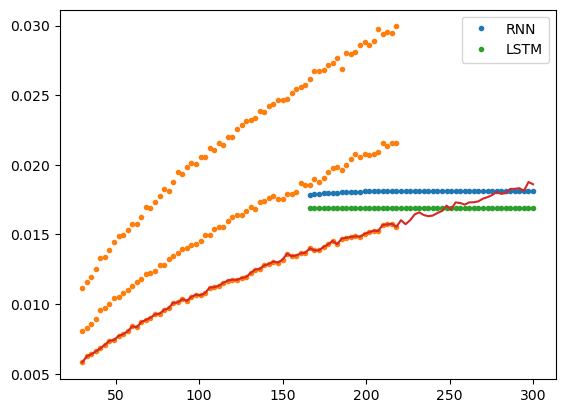

In [58]:
import matplotlib.pyplot as plt
plt.plot(tr_1['t'].iloc[50:], rnn_y_pred, '.', label='RNN')
plt.plot(tr_combined['t'], tr_combined['L'], '.')
plt.plot(tr_2['t'].iloc[50:], lstm_y_pred, '.', label='LSTM')
plt.plot(tr_2['t'], tr_2['L'])
plt.legend()
plt.show()

#### comparison of models

In [59]:
tr_combined = pd.concat([tr_1, tr_2, tr_3])


In [60]:
def likelihood(params, model):
    """
    A general likelihood function for a model with Gaussian errors.
    
    :param params: The parameters of the model.
    :param model: The model function.
    
    :return: The likelihood of the model given the data.
    """
    model_y = model(data['t'], params)
    # print(model_y.shape)
    return np.sum([d.logpdf(m) for d, m in zip(data_distribution, model_y)])

Digestive
predicted mean: 7.882179806307386e-07
true mean: 8.034291866766941e-07
predicted std: 8.18019913091328e-08
true std: 5.8005888939756295e-08

Hobnob
predicted mean: 5.165290698477061e-07
true mean: 4.96368880029679e-07
predicted std: 1.0527615756955756e-07
true std: 8.003103851757349e-08

Rich Tea
predicted mean: 3.297195784056182e-07
true mean: 3.038970573515411e-07
predicted std: 1.0690429827239919e-07
true std: 4.70262511627653e-08

In [61]:
def prior_transform_one(u):
    """
    Transform the uniform random variables `u` to the model parameters.
    
    :param u: Uniform random variables
    
    :return: Model parameters
    """
    return [p.ppf(u_) for p, u_ in zip(tr3_priors, u)]

In [62]:
def washburn(gamma,r,t,phi,eta):
    """
    REDO
    A first order rate equation.
    
    :param gamma: The time to evaluate the rate equation at.
    :param r: The rate constant.
    :param t: The initial concentration of A.
    :param phi: The initial concentration of A.
    :param eta: The initial concentration of A.
    
    :return: The concentration of A at time t.
    """
    
    numerator = gamma*r*t*np.cos(phi)
    denominator = 2*eta
    
    L = np.sqrt(numerator / denominator)
    
    # L at time t
    return L

In [63]:
def model_one(t, params):
    """
    A simpler single Gaussian model.
    
    :param t: The x values
    :param params: The model parameters
    
    :return: The y values
    """
    t=t.values.reshape(-1,1)
    r = distributions[biscuit]['mean']
    # print(t)
    # print(params[0])
    gamma=6.78e-2
    phi=1.45
    eta=9.93e-4 
    
    L = washburn(gamma,r,t,phi,eta)
    
    # L at time t.
    return L

In [64]:
def likelihood_one(params):
    """
    The likelihood function for the simpler model.
    
    :param params: The model parameters
    
    :return: The likelihood
    """
    return likelihood(params, model_one)

In [65]:


def prior_transform_two(u):
    """
    Transform the uniform random variables `u` to the model parameters for the more complex model.
    
    :param u: Uniform random variables
    
    :return: Model parameters
    """
    return [p.ppf(u_) for p, u_ in zip(tr3_priors_two, u)]

In [66]:
def model_three(t, params):
    t=t.values.reshape(-1,1)
    
    L = reg_model(r,t)
        
    # L at time t.
    return L   

In [67]:
def model_two(t, params):
    """
    A simpler single Gaussian model.
    
    :param t: The x values
    :param params: The model parameters
    
    :return: The y values
    """
    t=t.values.reshape(-1,1)
    a = params[0]
    r =  distributions[biscuit]['mean']
    gamma=6.78e-2
    phi=1.45
    eta=9.93e-4 
    
    L = washburn(gamma,r,t,phi,eta)
    
    # L_corrected = (b*r+a)*L
    L_corrected = (a)*L 
    
    # L at time t.
    return L_corrected

In [68]:
def old_model_two(t, params):
    """
    A more complex double Gaussian model.
    
    :param t: The time values
    :param params: The model parameters
    
    :return: The y values
    """
    t = t.values.reshape(-1,1)
    
    # print(X_.shape)
    r = params[0]
    # y = np.full((t.shape[0], 1), params[0])
    # print(y)
    # print(y.ravel())
    # print(y.shape)
    
    L_prediction = (1.54e+02*r + -1.8e+07*(r**2) + 2.16e-05)*t + (-0.254*r + 9.33e+04*(r**2) + -3.76e-09)*(t**2) + (3.96e+03*r + 3.74e+09*(r**2) + 0.00272)
    
    # reg_prediction = model.predict(t)
    
    return L_prediction

def likelihood_two(params):
    """
    The likelihood function for the more complex model.
    
    :param params: The model parameters
    
    :return: The likelihood
    """
    return likelihood(params, model_two)



In [69]:
def likelihood_three(params):
    """
    The likelihood function for the more complex model.
    
    :param params: The model parameters
    
    :return: The likelihood
    """
    return likelihood(params, model_three)

In [70]:
# WORKING !!

import ultranest

import numpy as np
from scipy.stats import uniform, norm


tr3_priors = []  

for biscuit in biscuits:
    data = distributions[biscuit]['tr_vals']

    data_distribution = [norm(loc=loc, scale=scale) for loc, scale in zip(data['L'], data['dL'])]

    sampler_one = ultranest.ReactiveNestedSampler([], likelihood_one, prior_transform_one)
    sampler_one.run(show_status=False)
    sampler_one.print_results()

    tr3_priors_two = [uniform(0, 10)]

    sampler_two = ultranest.ReactiveNestedSampler(['a'], likelihood_two, prior_transform_two)
    sampler_two.run(show_status=False)
    sampler_two.print_results()
    
    distributions[biscuit]['correction'] = sampler_two.results['posterior']['mean'][0]
    
    log_B = sampler_two.results['logz'] - sampler_one.results['logz']
    print(log_B)

[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-1e+05  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = -1.084e+05 +- 2.994e-11
[ultranest] Effective samples strategy satisfied (ESS = 400.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 40 minimum live points (dlogz from 0.00 to 0.00, need <0.5)
[ultranest]   logZ error budget: single: inf bs:0.00 tail:0.69 total:0.69 required:<0.50
[ultranest] done iterating.

logZ = -108364.256 +- 0.693
  single instance: logZ = -108364.256 +- nan
  bootstrapped   : logZ = -108364.256 +- -0.000
  tail           : logZ = +- 0.693
insert order U test : converged: True correlation: inf iterations


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=4e+02  
[ultranest] Likelihood function evaluations: 5894
[ultranest]   logZ = 409.8 +- 0.09241
[ultranest] Effective samples strategy satisfied (ESS = 1256.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.03 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = 409.784 +- 0.205
  single instance: logZ = 409.784 +- 0.154
  bootstrapped   : logZ = 409.784 +- 0.202
  tail           : logZ = +- 0.035
insert order U test : converged: True correlation: inf iterations

    a                   : 1.11662│ ▁▁▁▁▁▁▁▁▁▁▃▄▄▄▆▅▆▇▇▇▇▅▄▅▄▂▂▂▁▁▁▁▁▁  ▁ │1.11867    1.11763 +- 0.00025

108774.04045672907
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=7e+02  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = 655.9 +- 5.492

[ultranest] Explored until L=7e+02  
[ultranest] Likelihood function evaluations: 5309
[ultranest]   logZ = 647.5 +- 0.09249
[ultranest] Effective samples strategy satisfied (ESS = 1276.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.09 tail:0.03 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = 647.488 +- 0.165
  single instance: logZ = 647.488 +- 0.141
  bootstrapped   : logZ = 647.489 +- 0.161
  tail           : logZ = +- 0.033
insert order U test : converged: True correlation: inf iterations

    a                   : 0.9958│ ▁▁▁▁▁▁▁▂▂▂▃▄▄▅▇▇▇▇▇▆▅▆▄▃▄▂▁▁▁▁▁▁▁▁▁ ▁ │1.0038    0.9995 +- 0.0010

-8.409854047410022
[ultranest] Sampling 400 live points from prior ...
[ultranest] Explored until L=-2e+02  
[ultranest] Likelihood function evaluations: 400
[ultranest]   logZ = -162.1 +- 2.696e-

[ultranest] Explored until L=7e+02  
[ultranest] Likelihood function evaluations: 4902
[ultranest]   logZ = 649.2 +- 0.109
[ultranest] Effective samples strategy satisfied (ESS = 1247.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.11 tail:0.04 total:0.12 required:<0.50
[ultranest] done iterating.

logZ = 649.144 +- 0.289
  single instance: logZ = 649.144 +- 0.135
  bootstrapped   : logZ = 649.160 +- 0.286
  tail           : logZ = +- 0.041
insert order U test : converged: True correlation: inf iterations

    a                   : 0.9285│ ▁▁ ▁▁▁▁▁▂▂▃▄▃▄▆▅▆▇▆▆▄▆▄▂▂▂▂▁▁▁▁▁▁▁▁ ▁ │0.9415    0.9346 +- 0.0016

811.2610374467876


In [71]:
sampler_two.results['logz'], sampler_two.results['logzerr']

(649.1443723392338, 0.2893628549568135)

In [72]:
log_B = sampler_two.results['logz'] - sampler_one.results['logz']
log_B

811.2610374467876

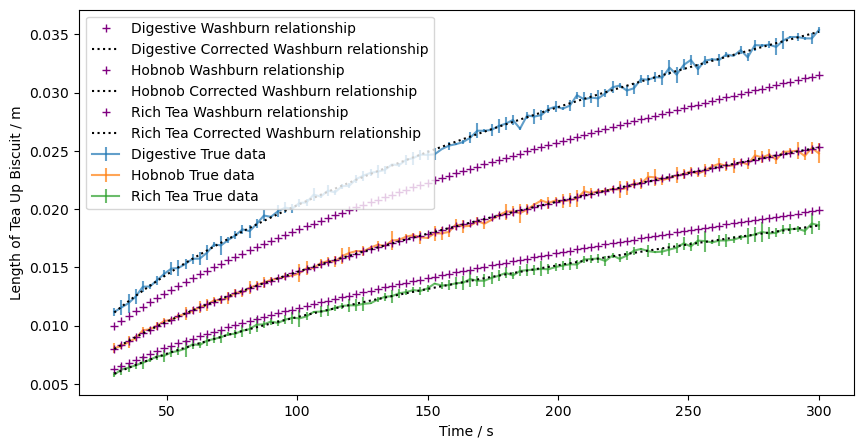

In [73]:
# washburn model fittings

fig, ax = plt.subplots(figsize=(10,5))


for i, biscuit in enumerate(biscuits):
    data = distributions[biscuit]['tr_vals']
    x = data["t"]
    y = data["L"]
    dy = data["dL"]
    
    washburn_data_rfc = washburn(6.78e-2, distributions[biscuit]['mean'], data["t"], 1.45, 9.93e-4 )
    ax.errorbar(x,y,dy,label=f"{biscuit} True data", alpha=0.7, color=f"C{i}")
    
    ax.plot(data["t"], washburn_data_rfc, marker='+', linestyle='', color="purple", zorder=3, label=f'{biscuit} Washburn relationship') 
    
    correction = distributions[biscuit]['correction']
    # correction =  1.117926  
    ax.plot(data["t"],  ((correction)*washburn_data_rfc), linestyle=':', color="black", zorder=5, label=f'{biscuit} Corrected Washburn relationship') 
    
    
ax.set_xlabel("Time / s")
ax.set_ylabel("Length of Tea Up Biscuit / m")
ax.legend()
plt.show()

Another dataset has been provided, which investigates the capillary flow rate of the tea in the
biscuits. This involved taking a blind sample of each of the biscuits and measuring the length
that the tea soaked up the biscuit in a time range from 30 s to 300 s.

• the tea surface tension was measured at 6.78 × 10−2 N m−1.

• the contact angle was 1.45 rad.

• the tea dynamic viscosity was 9.93 × 10−4 Pa s.

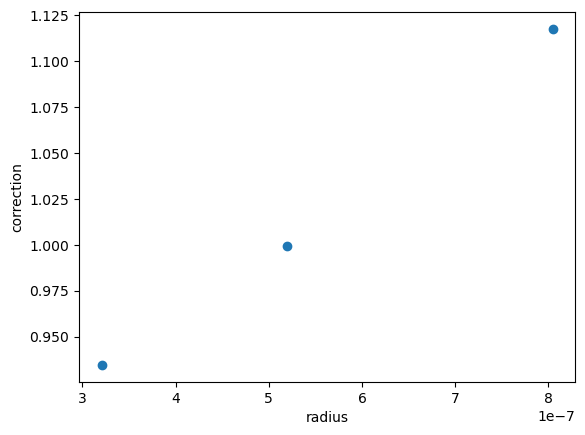

In [74]:
fig, ax = plt.subplots()

radii_mean = np.zeros(len(biscuits))
corrections = np.zeros(len(biscuits))
for i, biscuit in enumerate(biscuits):
    radii_mean[i] = (distributions[biscuit]['mean'])
    corrections[i] = (distributions[biscuit]['correction'])
    
ax.scatter(radii_mean, corrections)

ax.set_xlabel('radius')
ax.set_ylabel('correction');

In [75]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

x = radii_mean.reshape(-1, 1)
y = corrections.reshape(-1, 1)

model.fit(x,y)

print(model.coef_)
print(model.intercept_)

[[380879.12269274]]
[0.808504]


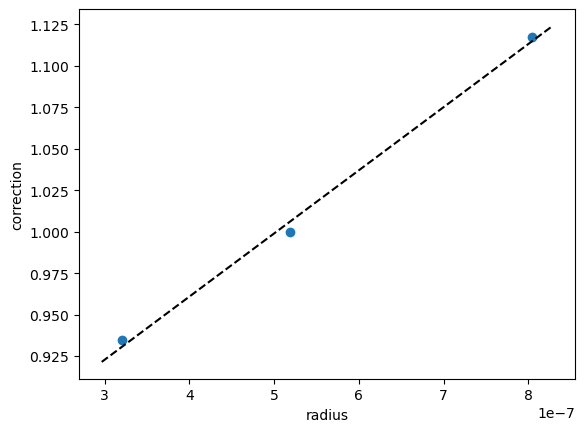

In [76]:
fig, ax = plt.subplots()

radii_mean = np.zeros(len(biscuits))
corrections = np.zeros(len(biscuits))
for i, biscuit in enumerate(biscuits):
    radii_mean[i] = (distributions[biscuit]['mean'])
    corrections[i] = (distributions[biscuit]['correction'])
    
ax.scatter(radii_mean, corrections)
x_vals = np.array(ax.get_xlim())
y_vals = model.intercept_[0] + model.coef_[0][0] * x_vals
ax.plot(x_vals, y_vals, linestyle='--', color='black')

ax.set_xlabel('radius')
ax.set_ylabel('correction');

This figure suggests there may be a linear relationship between the correction factor and the pore radius of a biscuit. However, with only 3 datapoints, this relationship is not reliable. 

Assessment: You have been tasked with investigating the available data and outlining
the analysis that you have performed in a written report. The aim is not to do the
most analysis possible but to find a coherent story in the analysis and present
this. Some examples of questions that the team are interested in include:

• Can a machine learning algorithm be used to identify the different types of biscuits? YES, USING RFC

• How is the pore radius different between the three types of biscuits? HISTOGRAM DONE

• How accurate is the Washburn equation for biscuits, and can a machine learning
regressor perform better? GOOD FOR HOBNOBS, BAD FOR OTHERS

You have been asked to write a report on the available data, perform an analysis, and
outline the data results. Furthermore, highlight and describe how the team might use
these data in future data-driven investigations.